In [ ]:
# CELL 1: SETUP AND DATA DOWNLOAD
import os

# 1. Define Paths
# Ensure the data goes into the correct directory structure
project_root = '/content'
data_dir = os.path.join(project_root, 'data')
os.makedirs(data_dir, exist_ok=True)

# 2. Move to data directory
%cd {data_dir}

# 3. Download the dataset folder from Google Drive
!pip install gdown -q
print("Downloading folder from Drive...")
# Downloads the folder structure containing the Linemod dataset
!gdown --folder "https://drive.google.com/drive/folders/19ivHpaKm9dOrr12fzC8IDFczWRPFxho7" --remaining-ok

# 4. Find and Unzip the Linemod dataset
# The download creates a folder (usually named 'DenseFusion')
# Search for 'Linemod_preprocessed.zip' recursively and extract it
import glob
zip_files = glob.glob("**/Linemod_preprocessed.zip", recursive=True)

if zip_files:
    zip_path = zip_files[0]
    print(f"Unzipping {zip_path}...")
    !unzip -q -o "{zip_path}"
    print("Extraction complete!")
else:
    print("Error: Linemod_preprocessed.zip not found. Check the download.")

# 5. Return to Project Root
%cd {project_root}

/content/data
Retrieving folder contents
Processing file 1YFUra533pxS_IHsb9tB87lLoxbcHYXt8 Linemod_preprocessed.zip
Processing file 1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6 trained_checkpoints.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1YFUra533pxS_IHsb9tB87lLoxbcHYXt8
From (redirected): https://drive.google.com/uc?id=1YFUra533pxS_IHsb9tB87lLoxbcHYXt8&confirm=t&uuid=d6168ac4-aac7-4575-9b56-9ff0945dc4f1
To: /content/data/DenseFusion/Linemod_preprocessed.zip
100% 8.97G/8.97G [01:31<00:00, 98.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6
From (redirected): https://drive.google.com/uc?id=1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6&confirm=t&uuid=b0233bcf-ad80-4a88-bd0c-e58370518ab5
To: /content/data/DenseFusion/trained_checkpoints.zip
100% 253M/253M [00:02<00:00, 90.1MB/s]
Download completed
Unzipping DenseFusion/Linemod_p

In [ ]:
# CELL 2: GENERATE SYNTHETIC TRAINING DATA WITH MULTIPLE OBJECTS PER IMAGE
import os
import cv2
import numpy as np
import random
import yaml
import shutil
import requests
from tqdm import tqdm

# --- 1. CONFIGURATION ---
SOURCE_ROOT = '/content/data/Linemod_preprocessed/data'
DEST_ROOT = '/content/datasets'
BG_CACHE_DIR = '/content/backgrounds_cache'

NUM_COLLAGES = 1500     # Number of synthetic images to generate
MAX_OBJECTS_PER_IMG = 4 # Maximum objects per image

# Valid Object IDs (excluding 3 and 7)
valid_obj_ids = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]

# Map original IDs to sequential class indices for YOLO
id_map = {obj_id: i for i, obj_id in enumerate(valid_obj_ids)}
obj_folders = [f"{i:02d}" for i in valid_obj_ids]

# --- 2. SETUP DIRECTORIES ---
if os.path.exists(DEST_ROOT): shutil.rmtree(DEST_ROOT)
if not os.path.exists(BG_CACHE_DIR): os.makedirs(BG_CACHE_DIR)

for split in ['train', 'val']:
    for dtype in ['images', 'labels']:
        os.makedirs(os.path.join(DEST_ROOT, dtype, split), exist_ok=True)

# --- 3. DOWNLOAD RANDOM BACKGROUNDS ---
print("🌍 Downloading random backgrounds...")
target_bg_count = 50
existing_bgs = [f for f in os.listdir(BG_CACHE_DIR) if f.endswith('.jpg')]

if len(existing_bgs) < target_bg_count:
    for i in range(target_bg_count - len(existing_bgs)):
        try:
            r = requests.get("https://picsum.photos/640/640", timeout=5)
            if r.status_code == 200:
                with open(os.path.join(BG_CACHE_DIR, f"bg_new_{i}.jpg"), "wb") as f:
                    f.write(r.content)
        except: pass

bg_files = [os.path.join(BG_CACHE_DIR, f) for f in os.listdir(BG_CACHE_DIR) if f.endswith('.jpg')]
if not bg_files: raise RuntimeError("❌ No backgrounds found!")

# --- 4. ROTATION FUNCTION ---
def rotate_image(image, angle):
    """Rotate image by given angle and adjust canvas size to fit rotated image"""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    return cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

# --- 5. LOAD OBJECTS (RAW - NO LIGHTING MODIFICATIONS) ---
print("♻️  Preparing original objects...")
objects_cache = []

for folder_str in tqdm(obj_folders):
    class_id = id_map[int(folder_str)]
    img_dir = os.path.join(SOURCE_ROOT, folder_str, 'rgb')
    mask_dir = os.path.join(SOURCE_ROOT, folder_str, 'mask')

    if not os.path.exists(img_dir): continue
    # Load first 50 images from each object category
    fnames = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])[:50]

    for fname in fnames:
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname)

        if os.path.exists(mask_path):
            # Read the pure image without modifications
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Crop to object bounding box
            x, y, w, h = cv2.boundingRect(mask)
            if w > 5 and h > 5:
                crop_img = img[y:y+h, x:x+w]
                crop_mask = mask[y:y+h, x:x+w]
                _, crop_mask = cv2.threshold(crop_mask, 127, 255, cv2.THRESH_BINARY)

                objects_cache.append({'cls': class_id, 'img': crop_img, 'mask': crop_mask})

# --- 6. GENERATE COLLAGES ---
print("🚀 Generating Dataset...")
for i in tqdm(range(NUM_COLLAGES)):
    # Load random background
    bg_path = random.choice(bg_files)
    bg = cv2.imread(bg_path)
    bg = cv2.resize(bg, (640, 640))
    h_bg, w_bg = bg.shape[:2]

    labels = []
    occupied_mask = np.zeros((h_bg, w_bg), dtype=np.uint8)

    num_objs = random.randint(1, MAX_OBJECTS_PER_IMG)

    for _ in range(num_objs):
        obj_data = random.choice(objects_cache)
        curr_img = obj_data['img'].copy()
        curr_mask = obj_data['mask'].copy()

        # Apply rotation and scaling
        angle = random.randint(-180, 180)  # Full rotation
        curr_img = rotate_image(curr_img, angle)
        curr_mask = rotate_image(curr_mask, angle)

        h_obj, w_obj = curr_img.shape[:2]
        scale = random.uniform(0.4, 0.9)
        new_w, new_h = int(w_obj * scale), int(h_obj * scale)
        if new_w <=0 or new_h <=0: continue

        curr_img = cv2.resize(curr_img, (new_w, new_h))
        curr_mask = cv2.resize(curr_mask, (new_w, new_h))

        # Find non-overlapping placement
        placed = False
        for attempt in range(20):
            x_off = random.randint(0, w_bg - new_w)
            y_off = random.randint(0, h_bg - new_h)
            roi_mask = occupied_mask[y_off:y_off+new_h, x_off:x_off+new_w]
            if np.sum(cv2.bitwise_and(roi_mask, curr_mask)) == 0:
                placed = True
                break

        if not placed: continue

        # Paste object onto background using alpha blending
        roi_bg = bg[y_off:y_off+new_h, x_off:x_off+new_w]
        mask_float = curr_mask.astype(float) / 255.0
        mask_3c = cv2.merge([mask_float]*3)

        bg[y_off:y_off+new_h, x_off:x_off+new_w] = (curr_img * mask_3c + roi_bg * (1 - mask_3c)).astype(np.uint8)
        occupied_mask[y_off:y_off+new_h, x_off:x_off+new_w] = cv2.bitwise_or(roi_mask, curr_mask)

        # Create YOLO format label (class_id x_center y_center width height - normalized)
        labels.append(f"{obj_data['cls']} {(x_off+new_w/2)/w_bg:.6f} {(y_off+new_h/2)/h_bg:.6f} {new_w/w_bg:.6f} {new_h/h_bg:.6f}")

    # Save image and labels
    subset = 'val' if i < (NUM_COLLAGES * 0.15) else 'train'
    fname = f"collage_{i:05d}"
    cv2.imwrite(os.path.join(DEST_ROOT, 'images', subset, fname+'.jpg'), bg)
    if labels:
        with open(os.path.join(DEST_ROOT, 'labels', subset, fname+'.txt'), 'w') as f:
            f.write('\n'.join(labels))

# --- 7. ADD REAL IMAGES (Only folder 02 for context) ---
print("📸 Copying real images...")
folder_02 = os.path.join(SOURCE_ROOT, '02', 'rgb')
gt_02 = os.path.join(SOURCE_ROOT, '02', 'gt.yml')

if os.path.exists(folder_02):
    with open(gt_02, 'r') as f: gt_data = yaml.safe_load(f)
    for k, v in gt_data.items():
        fname = f"{k:04d}.png"
        src = os.path.join(folder_02, fname)
        if not os.path.exists(src): continue

        img = cv2.imread(src)
        h, w = img.shape[:2]

        cv2.imwrite(os.path.join(DEST_ROOT, 'images', 'train', f"real_02_{fname}"), img)

        rl = []
        for ann in v:
            if int(ann['obj_id']) in id_map:
                b = ann['obj_bb']
                rl.append(f"{id_map[int(ann['obj_id'])]} {(b[0]+b[2]/2)/w:.6f} {(b[1]+b[3]/2)/h:.6f} {b[2]/w:.6f} {b[3]/h:.6f}")

        if rl:
            with open(os.path.join(DEST_ROOT, 'labels', 'train', f"real_02_{fname}".replace('.png','.txt')), 'w') as f:
                f.write('\n'.join(rl))

# --- 8. CREATE YAML CONFIGURATION ---
names = ['ape', 'benchvise', 'camera', 'can', 'cat', 'driller', 'duck', 'eggbox', 'glue', 'holepuncher', 'iron', 'lamp', 'phone']
with open('/content/linemod.yaml', 'w') as f:
    f.write(f"path: {DEST_ROOT}\ntrain: images/train\nval: images/val\nnc: 13\nnames: {names}")

print("\n✅ GENERATION COMPLETED (Without lighting filters).")

🌍 Scaricamento sfondi casuali...
♻️  Preparazione oggetti originali...


100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


🚀 Generazione Dataset...


100%|██████████| 1500/1500 [00:12<00:00, 117.81it/s]


📸 Copia immagini reali...

✅ GENERAZIONE COMPLETATA (Senza filtri luce).


In [ ]:
# CELL 3: CREATE DIRECTORY STRUCTURE FOR YOLO DATASET
import os

# Base directory for the dataset
base_dir = '/content/datasets'

# Create the directory structure required by YOLO
# datasets/
# ├── images/ (train, val)
# └── labels/ (train, val)
for split in ['train', 'val']:
    for dtype in ['images', 'labels']:
        dir_path = os.path.join(base_dir, dtype, split)
        os.makedirs(dir_path, exist_ok=True)

print("Directory structure created successfully!")

Directory structure created successfully!


In [ ]:
# CELL 4: TRAIN YOLO MODEL ON SYNTHETIC DATA
!pip install ultralytics
from ultralytics import YOLO
import torch

# --- 1. HARDWARE CHECK ---
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: Using CPU! Go to Runtime > Change runtime type > T4 GPU")

# --- 2. MODEL SELECTION ---
# YOLO11 Small is perfect for T4 GPU
model = YOLO('yolo11s.pt')

print("🚀 Starting Training on Colab T4...")

# --- 3. TRAINING LOOP ---
results = model.train(
    data='/content/linemod.yaml',

    # --- DURATION ---
    epochs=50,           # Increased to 50. Synthetic data requires more time to converge
    patience=15,         # Early stopping if no improvement for 15 epochs

    # --- HARDWARE ---
    imgsz=640,
    batch=16,            # Batch size 16 is safer and more stable for generalization on difficult datasets
    device=0,
    workers=2,
    amp=True,            # Mixed Precision ON (Essential for T4)
    cache=False,         # Save RAM

    # --- AUGMENTATION (Tuned for "Black-on-Black" scenarios) ---
    mosaic=0.5,          # REDUCED. Data is already collaged, don't overdo it
    mixup=0.0,           # DISABLED. Critical! We want solid objects, not transparent ghosts

    degrees=10.0,        # Light rotation (already done in generator script)
    scale=0.5,           # Zoom in/out
    translate=0.1,       # Light translation
    fliplr=0.5,          # Horizontal flip OK

    # --- LIGHTING (YOLO applies these instead of our script) ---
    hsv_h=0.015,         # Light color shift
    hsv_s=0.7,           # Saturation
    hsv_v=0.4,           # BRIGHTNESS (Value): 0.4 is perfect
                         # Teaches the model: "The phone is the same whether dark (black) or illuminated (gray)"

    close_mosaic=10,     # Last 10 epochs turn off mosaic to refine edges

    # --- SAVE RESULTS ---
    # WARNING: This saves directly to Google Drive
    project='/content/drive/MyDrive/YOLO_Runs',
    name='yolo11_collage_run',
    verbose=True,
    exist_ok=True,
    save=True
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ GPU: Tesla T4
🚀 Starting Training on Colab T4...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/linemod.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscr

In [ ]:
# CELL 5: DOWNLOAD TRAINING RESULTS
import shutil
import os
from google.colab import files

# --- CONFIGURATION ---
# Path to the folder you want to download
# Example: '/content/runs' contains all YOLO results
folder_to_download = '/content/drive/MyDrive/YOLO_Runs-'

# Name of the final zip file (without .zip extension)
output_filename = 'i_miei_risultati_yolo'

# --- 1. VERIFY AND COMPRESS ---
if os.path.exists(folder_to_download):
    print(f"📦 Compressing folder: {folder_to_download}...")

    # Create zip archive
    # shutil.make_archive automatically creates the .zip file
    shutil.make_archive(output_filename, 'zip', folder_to_download)

    zip_path = f"{output_filename}.zip"

    # Check file size
    size_mb = os.path.getsize(zip_path) / (1024 * 1024)
    print(f"✅ Archive created: {zip_path} ({size_mb:.2f} MB)")

    # --- 2. AUTOMATIC DOWNLOAD ---
    print("⬇️ Starting download...")
    files.download(zip_path)

else:
    print(f"❌ Error: The folder '{folder_to_download}' does not exist.")
    print("Check the path. Here's what's in the current directory:")
    print(os.listdir('/content/'))

📦 Sto comprimendo la cartella: /content/drive/MyDrive/YOLO_Runs...
✅ Archivio creato: i_miei_risultati_yolo.zip (83.56 MB)
⬇️ Avvio del download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# CELL 6: AUTO-LABELING - USE TRAINED MODEL TO ADD MISSING LABELS
import os
import cv2
import numpy as np
import yaml
import shutil
from ultralytics import YOLO
from tqdm import tqdm

# --- CONFIGURATION ---
SOURCE_ROOT = '/content/data/Linemod_preprocessed/data'  # Original dataset folder
DEST_ROOT = '/content/dataset_AUTOLABELED'               # New destination folder
MODEL_PATH = '/content/drive/MyDrive/YOLO_Runs/yolo11_collage_run/weights/best.pt' # YOUR BEST MODEL

# Auto-Labeling Parameters
CONF_THRESHOLD = 0.80   # Must be very confident to add a label
IOU_THRESHOLD = 0.45    # If overlaps >45% with ground truth label, discard (it's a duplicate)

# Object IDs
valid_obj_ids = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
id_map = {obj_id: i for i, obj_id in enumerate(valid_obj_ids)}
obj_folders = [f"{i:02d}" for i in valid_obj_ids]

# --- SETUP ---
if os.path.exists(DEST_ROOT): shutil.rmtree(DEST_ROOT)
for split in ['train', 'val']:
    for dtype in ['images', 'labels']:
        os.makedirs(os.path.join(DEST_ROOT, dtype, split), exist_ok=True)

# Load Model
print(f"🧠 Loading model: {MODEL_PATH} ...")
model = YOLO(MODEL_PATH)

# --- HELPER FUNCTIONS ---
def convert_box_gt_to_yolo(size, box):
    """Convert bounding box from pixel coordinates to YOLO format (normalized)"""
    # box = [x, y, w, h] pixel -> [xc, yc, w, h] normalized
    dw, dh = 1. / size[0], 1. / size[1]
    xc = (box[0] + box[2] / 2.0) * dw
    yc = (box[1] + box[3] / 2.0) * dh
    w = box[2] * dw
    h = box[3] * dh
    return [xc, yc, w, h]

def compute_iou_yolo(box1, box2):
    """Calculate IoU between two boxes in YOLO format [xc, yc, w, h]"""
    # Simplified: converts to [x1, y1, x2, y2] first
    def to_corners(b):
        return [b[0]-b[2]/2, b[1]-b[3]/2, b[0]+b[2]/2, b[1]+b[3]/2]

    b1 = to_corners(box1)
    b2 = to_corners(box2)

    inter_x1 = max(b1[0], b2[0])
    inter_y1 = max(b1[1], b2[1])
    inter_x2 = min(b1[2], b2[2])
    inter_y2 = min(b1[3], b2[3])

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    b1_area = (b1[2]-b1[0]) * (b1[3]-b1[1])
    b2_area = (b2[2]-b2[0]) * (b2[3]-b2[1])

    union = b1_area + b2_area - inter_area
    return inter_area / union if union > 0 else 0

# --- MAIN LOOP ---
print("🚀 Starting Dataset Generation with Auto-Labeling...")
total_added = 0

for folder_str in obj_folders:
    folder_int = int(folder_str)

    # Paths
    rgb_dir = os.path.join(SOURCE_ROOT, folder_str, 'rgb')
    gt_path = os.path.join(SOURCE_ROOT, folder_str, 'gt.yml')

    if not os.path.exists(gt_path): continue

    with open(gt_path, 'r') as f: gt_data = yaml.safe_load(f)
    img_ids = list(gt_data.keys())

    # Split 90% train (to enrich training), 10% val
    split_idx = int(len(img_ids) * 0.10)

    for i, img_key in enumerate(tqdm(img_ids, desc=f"Folder {folder_str}")):
        subset = 'val' if i < split_idx else 'train'
        fname = f"{img_key:04d}.png"
        src_img_path = os.path.join(rgb_dir, fname)

        if not os.path.exists(src_img_path): continue

        # 1. Read image
        img = cv2.imread(src_img_path)
        h_img, w_img = img.shape[:2]

        # 2. Collect ORIGINAL Labels (Ground Truth)
        final_labels = [] # List of strings "cls xc yc w h"
        gt_boxes_yolo = [] # List of [cls, xc, yc, w, h] numeric for comparison

        annotations = gt_data.get(img_key, [])
        for ann in annotations:
            obj_id = int(ann['obj_id'])
            if obj_id in id_map:
                cls_id = id_map[obj_id]
                bbox_yolo = convert_box_gt_to_yolo((w_img, h_img), ann['obj_bb'])

                gt_boxes_yolo.append([cls_id] + bbox_yolo)
                final_labels.append(f"{cls_id} {bbox_yolo[0]:.6f} {bbox_yolo[1]:.6f} {bbox_yolo[2]:.6f} {bbox_yolo[3]:.6f}")

        # 3. AUTO-LABELING (Only if NOT in folder 02 and in TRAIN set)
        # Keep folder 02 "pure" as reference, and don't touch validation set
        if folder_int != 2 and subset == 'train':

            # Make prediction
            results = model.predict(img, conf=CONF_THRESHOLD, verbose=False, iou=0.4)

            for r in results:
                for box in r.boxes:
                    p_cls = int(box.cls[0])
                    p_conf = float(box.conf[0])
                    p_xywh = box.xywhn[0].tolist() # [xc, yc, w, h]

                    # CHECK: Does it already exist in GT?
                    is_duplicate = False
                    for gt_b in gt_boxes_yolo:
                        gt_cls = gt_b[0]
                        gt_geom = gt_b[1:]

                        # If same class AND high overlap -> It's the same object
                        if p_cls == gt_cls:
                            iou = compute_iou_yolo(p_xywh, gt_geom)
                            if iou > IOU_THRESHOLD:
                                is_duplicate = True
                                break

                    # If NOT duplicate, it's a new object! Add it.
                    if not is_duplicate:
                        final_labels.append(f"{p_cls} {p_xywh[0]:.6f} {p_xywh[1]:.6f} {p_xywh[2]:.6f} {p_xywh[3]:.6f}")
                        total_added += 1

        # 4. SAVE
        # Unique name: folder_filename
        dst_fname = f"{folder_str}_{fname}"

        # Copy image
        cv2.imwrite(os.path.join(DEST_ROOT, 'images', subset, dst_fname), img)

        # Write labels
        if final_labels:
            with open(os.path.join(DEST_ROOT, 'labels', subset, dst_fname.replace('.png', '.txt')), 'w') as f:
                f.write('\n'.join(final_labels))

print(f"\n✅ DATASET GENERATED!")
print(f"   ➕ Extra labels added automatically: {total_added}")
print(f"   📁 Saved in: {DEST_ROOT}")

# --- CREATE YAML CONFIGURATION ---
names = ['ape', 'benchvise', 'camera', 'can', 'cat', 'driller', 'duck', 'eggbox', 'glue', 'holepuncher', 'iron', 'lamp', 'phone']
with open(os.path.join(DEST_ROOT, 'data.yaml'), 'w') as f:
    f.write(f"path: {DEST_ROOT}\ntrain: images/train\nval: images/val\nnc: 13\nnames: {names}")

🧠 Caricamento modello: /content/drive/MyDrive/YOLO_Runs/yolo11_collage_run/weights/best.pt ...
🚀 Inizio Generazione Dataset con Auto-Labeling...


Folder 15: 100%|██████████| 1243/1243 [01:08<00:00, 18.17it/s]


✅ DATASET GENERATO!
   ➕ Etichette extra aggiunte automaticamente: 67343
   📁 Salvato in: /content/dataset_AUTOLABELED


In [ ]:
# CELL 7: VISUALIZE BOUNDING BOXES ON IMAGES
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

def visualize_bbox(image_path):
    """
    Visualize YOLO Bounding Boxes on a specific image
    
    Args:
        image_path: Path to the image file
    """

    # 1. Define Classes (same order as data.yaml)
    class_names = [
        'ape', 'benchvise', 'camera', 'can', 'cat',
        'driller', 'duck', 'eggbox', 'glue', 'holepuncher',
        'iron', 'lamp', 'phone'
    ]

    # Generate random colors for each class to distinguish them
    np.random.seed(42)
    colors = np.random.uniform(0, 255, size=(len(class_names), 3))

    # 2. Load Image
    if not os.path.exists(image_path):
        print(f"❌ Error: Image not found at {image_path}")
        return

    img = cv2.imread(image_path)
    if img is None:
        print("❌ Error: Unable to read image file.")
        return

    h_img, w_img, _ = img.shape

    # 3. Derive Label Path
    # Replace 'images' with 'labels' and extension with .txt
    label_path = image_path.replace('images', 'labels').rsplit('.', 1)[0] + '.txt'

    if not os.path.exists(label_path):
        print(f"⚠️ Warning: No label file found for this image ({label_path})")
        # Show the empty image anyway
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        return

    # 4. Read and Draw Boxes
    with open(label_path, 'r') as f:
        lines = f.readlines()

    print(f"✅ Found {len(lines)} objects in the image.")

    for line in lines:
        parts = list(map(float, line.strip().split()))
        cls_id = int(parts[0])
        x_c, y_c, w, h = parts[1], parts[2], parts[3], parts[4]

        # Convert from YOLO (normalized) to Pixel coordinates
        x1 = int((x_c - w / 2) * w_img)
        y1 = int((y_c - h / 2) * h_img)
        x2 = int((x_c + w / 2) * w_img)
        y2 = int((y_c + h / 2) * h_img)

        # Get name and color
        label_text = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
        color = colors[cls_id]

        # Draw Rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # Draw Label with colored background
        (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (x1, y1 - 20), (x1 + text_w, y1), color, -1)
        cv2.putText(img, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    # 5. Visualization (Matplotlib is better on Colab than cv2.imshow)
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Visualization: {os.path.basename(image_path)}")
    plt.show()

# --- USAGE EXAMPLE ---
# Replace this path with a real one you created
# Example: visualize_bbox('/content/dataset_AUTOLABELED/images/train/01_0000.png')


✅ Trovati 4 oggetti nell'immagine.


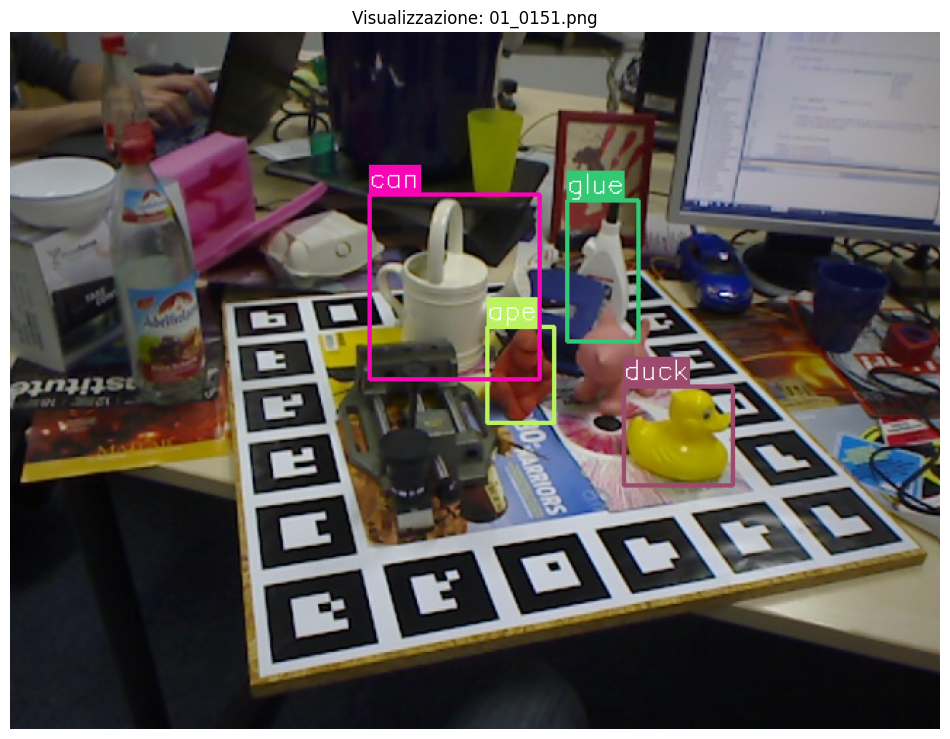

In [ ]:
# CELL 8: TEST VISUALIZATION FUNCTION
visualize_bbox('/content/dataset_AUTOLABELED/images/train/01_0151.png')

In [ ]:
# CELL 9: FINAL TRAINING ON AUTO-LABELED DATASET
from ultralytics import YOLO

# Use the 's' (Small) clean version
# Will automatically download standard weights if not found
model = YOLO('yolo11s.pt')

results = model.train(
    # The clean dataset with automatic labels
    data='/content/dataset_AUTOLABELED/data.yaml',

    # --- DURATION ---
    epochs=20,
    patience=15,

    # --- HARDWARE ---
    imgsz=640,
    batch=32,            # With the 's' model, use 16 to avoid running out of video memory (OOM)
    device=0,
    workers=4,
    
    # --- AUGMENTATION ---
    mosaic=1.0,          # Now that labels are good, mosaic is useful
    mixup=0.1,           # Light mixup

    degrees=10.0,
    fliplr=0.5,
    scale=0.5,

    # --- OUTPUT ---
    project='/content/drive/MyDrive/YOLO_Runs',
    name='yolo11s_autolabel_final', # Changed name to remind it's the S model
    save=True,
    exist_ok=True
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_AUTOLABELED/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_autolabel_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective